# Feature Interaction Analysis Using Model Class Reliance (MCR) for Emirates Airways

## Abstract
This notebook analyzes airline review features across Pre-, During-, and Post-COVID using MCR and SHAP-based interaction testing. The workflow:

- **Data Prep** – Loaded dataset, tagged reviews by COVID period.  
- **MCR Screening** – Computed MCR+/MCR–, labeled features as Core, Volatile, or No-use; kept Core + Volatile.  
- **Temporal Roles** – Compared feature stability shifts across periods.  
- **SHAP Interactions** – Trained LightGBM, ranked top-10 feature pairs, visualized heatmaps.  
- **Model Testing** – Added interaction terms, measured RMSE/R² lift.  
- **Stat Validation** – OLS, ANOVA, permutation, bootstrap → confirmed robust interactions.  
- **PDP/ICE** – Visualized 1D/2D partial dependence of top pairs.  
- **Shortlist vs Full** – Compared interactions using all features vs. MCR shortlist; shortlist gave cleaner signals.  
- **Why** – To identify stable vs. volatile drivers, uncover synergies, capture shifts across COVID, and ensure findings are statistically sound.  


### Load Full dataset and Pre,During and Post MCR + and - values

In [4]:
import pandas as pd
df_features = pd.read_csv(r"C:\Users\Samiksha\Downloads\Em_Featured_MCR.csv")   
df_pre      = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__mcr_df_em_pre_New.csv")  
df_during   = pd.read_csv(r"C:\Users\Samiksha\Downloads\C_mcr_df_em_during_New.csv") 
df_post     = pd.read_csv(r"C:\Users\Samiksha\Downloads\C_mcr_df_em_post_New.csv")  


print("Shapes:", df_features.shape, df_pre.shape, df_during.shape, df_post.shape)

display(df_features.head(3))
display(df_pre.head(3))
display(df_during.head(3))
display(df_post.head(3))

Shapes: (1475, 47) (29, 3) (29, 3) (29, 3)


,overall_rating,review_date,verified_flag,travel_class,seat_comfort,staff_service,ground_service,value_for_money,recommended,food_quality,...,travel_type_missing,type_Business,type_Couple,type_Family,type_Solo,type_Unknown,food_quality_missing,wifi_missing,entertainment_missing,ground_service_missing
0,5.0,2023-12-31,2,1,2,5,3.0,2,0,4.0,...,0,False,True,False,False,False,0,0,0,0
1,1.0,2023-12-26,1,1,3,3,1.0,1,0,2.0,...,0,False,False,True,False,False,0,1,0,0
2,1.0,2023-12-25,2,1,1,1,3.0,1,0,1.0,...,0,False,False,False,True,False,0,0,0,0


,variable,MCR-,MCR+
0,verified_flag,0.018229,0.020023
1,travel_class,0.015451,0.018747
2,seat_comfort,0.271827,0.287638


,variable,MCR-,MCR+
0,verified_flag,0.000000,2.022930
1,travel_class,0.000031,4.420600
2,seat_comfort,0.000004,9.232875


,variable,MCR-,MCR+
0,verified_flag,7.346189e-08,0.725187
1,travel_class,1.179982e-06,2.378635
2,seat_comfort,3.937557e-05,9.329931


In [6]:
import pandas as pd

# Load your dataset directly with the path
df_features = pd.read_csv(r"C:\Users\Samiksha\Downloads\Em_Featured_MCR.csv")

# Convert review_date to datetime
df_features["review_date"] = pd.to_datetime(df_features["review_date"])

# Function to tag covid period
def assign_covid_period(date):
    if date < pd.Timestamp("2020-01-01"):
        return "pre"
    elif pd.Timestamp("2020-01-01") <= date <= pd.Timestamp("2021-12-31"):
        return "during"
    else:
        return "post"

# Apply covid period labeling
df_features["covid_period"] = df_features["review_date"].apply(assign_covid_period)

# Split into subsets
df_pre_data = df_features[df_features["covid_period"] == "pre"]
df_during_data = df_features[df_features["covid_period"] == "during"]
df_post_data = df_features[df_features["covid_period"] == "post"]

# Sanity check
print("All data:", df_features.shape)
print("Pre-COVID:", df_pre_data.shape)
print("During COVID:", df_during_data.shape)
print("Post-COVID:", df_post_data.shape)


All data: (1475, 48)
Pre-COVID: (1080, 48)
During COVID: (153, 48)
Post-COVID: (242, 48)


## Dynamic Feature Categorization via Model Class Reliance (MCR)
 - Classifies features into Core, Volatile, or No-use
 - Uses thresholds: median of MCR+ and 25th percentile of MCR-
 - Core     = High MCR+ & High MCR- (stable importance)
 - Volatile = High MCR+ & Low MCR-  (unstable utility)
 - No-use   = Otherwise (limited contribution)
 - Adds period label (e.g., Pre-COVID) for temporal comparison

In [8]:
def classify_features_dynamic(mcr_df, period):
    plus_median = mcr_df["MCR+"].median()
    minus_q25   = mcr_df["MCR-"].quantile(0.25)

    cats = []
    for _, row in mcr_df.iterrows():
        f, mcr_minus, mcr_plus = row["variable"], row["MCR-"], row["MCR+"]
        if mcr_plus >= plus_median and mcr_minus >= minus_q25:
            cats.append((f, "Core"))
        elif mcr_plus >= plus_median and mcr_minus < minus_q25:
            cats.append((f, "Volatile"))
        else:
            cats.append((f, "No-use"))
    return pd.DataFrame(cats, columns=["Feature","Category"]).assign(Period=period)

# Apply for Pre
pre_classes = classify_features_dynamic(df_pre, "Pre-COVID")
display(pre_classes.sort_values("Category"))

,Feature,Category,Period
14,lounge_sentiment,Core,Pre-COVID
21,topic_business_experience,Core,Pre-COVID
15,entertainment_sentiment,Core,Pre-COVID
23,topic_baggage,Core,Pre-COVID
13,refunds_sentiment,Core,Pre-COVID
11,staff_sentiment,Core,Pre-COVID
10,seat_sentiment,Core,Pre-COVID
18,topic_entertainment,Core,Pre-COVID
9,food_sentiment,Core,Pre-COVID
7,wifi_score,Core,Pre-COVID


## Feature Classification with Model Class Reliance (MCR)

- Categorizes features as Core, Volatile, or No-use
- Thresholds: median of MCR+ (importance), cutoff of MCR- (stability)
- Core = high MCR+ and MCR- above cutoff (stable importance)
- Volatile = high MCR+ and MCR- near zero (unstable utility)
- No-use = low MCR+ regardless of MCR-
- Returns labeled DataFrame with feature, category, MCR-, MCR+, and period

In [9]:
def classify_features_mcr(mcr_df, period, minus_cutoff=0.05, plus_cutoff=None):
    """
    Classify features into Core, Volatile, or No-use using MCR+ and MCR-.
    
    Theory:
    - Core      = consistently important (MCR+ high, MCR- not close to 0)
    - Volatile  = conditionally important (MCR+ high, MCR- ~ 0)
    - No-use    = weak overall (MCR+ low)
    """
    
    # Decide thresholds
    if plus_cutoff is None:
        plus_cutoff = mcr_df["MCR+"].median()   # data-driven cutoff for "important"
    
    cats = []
    for _, row in mcr_df.iterrows():
        f, mcr_minus, mcr_plus = row["variable"], row["MCR-"], row["MCR+"]
        
        if mcr_plus < plus_cutoff:
            category = "No-use"
        else:
            if mcr_minus < minus_cutoff:   # very low stability
                category = "Volatile"
            else:
                category = "Core"
        
        cats.append((f, category, mcr_minus, mcr_plus))
    
    return pd.DataFrame(cats, columns=["Feature","Category","MCR-","MCR+"]).assign(Period=period)


# Example: Apply for Pre-COVID
pre_classes = classify_features_mcr(df_pre, "Pre-COVID")
display(pre_classes.sort_values("Category"))

,Feature,Category,MCR-,MCR+,Period
14,lounge_sentiment,Core,0.098084,0.118121,Pre-COVID
21,topic_business_experience,Core,0.110028,0.141676,Pre-COVID
15,entertainment_sentiment,Core,0.223625,0.256469,Pre-COVID
23,topic_baggage,Core,0.107216,0.130419,Pre-COVID
13,refunds_sentiment,Core,0.213300,0.230608,Pre-COVID
11,staff_sentiment,Core,0.544772,0.592821,Pre-COVID
10,seat_sentiment,Core,0.599539,0.649740,Pre-COVID
18,topic_entertainment,Core,0.135191,0.179596,Pre-COVID
9,food_sentiment,Core,0.271215,0.299706,Pre-COVID
7,wifi_score,Core,0.131872,0.143625,Pre-COVID


In [10]:
during_classes = classify_features_mcr(df_during, "During-COVID")
display(during_classes.sort_values("Category"))

,Feature,Category,MCR-,MCR+,Period
0,verified_flag,No-use,0.000000e+00,2.022930,During-COVID
26,wifi_missing,No-use,0.000000e+00,3.002781,During-COVID
24,travel_type_missing,No-use,0.000000e+00,0.000000,During-COVID
21,topic_business_experience,No-use,3.638344e-06,5.853826,During-COVID
20,topic_refunds_lounge,No-use,5.882353e-07,5.067870,During-COVID
19,topic_staff_customer_seating,No-use,3.005810e-05,5.090412,During-COVID
18,topic_entertainment,No-use,6.146696e-05,5.870930,During-COVID
17,airport_service_sentiment,No-use,2.372549e-05,4.862936,During-COVID
27,entertainment_missing,No-use,1.011619e-05,4.442758,During-COVID
12,baggage_sentiment,No-use,0.000000e+00,4.307373,During-COVID


In [11]:
post_classes = classify_features_mcr(df_post, "Post-COVID")
display(post_classes.sort_values("Category"))

,Feature,Category,MCR-,MCR+,Period
0,verified_flag,No-use,7.346189e-08,0.725187,Post-COVID
26,wifi_missing,No-use,6.795225e-07,2.692919,Post-COVID
25,food_quality_missing,No-use,0.000000e+00,1.899690,Post-COVID
24,travel_type_missing,No-use,0.000000e+00,0.000000,Post-COVID
22,topic_meals_food,No-use,3.145087e-06,2.948759,Post-COVID
21,topic_business_experience,No-use,7.808205e-03,3.295120,Post-COVID
20,topic_refunds_lounge,No-use,2.382803e-02,3.879077,Post-COVID
19,topic_staff_customer_seating,No-use,9.445565e-03,2.683531,Post-COVID
16,cleanliness_sentiment,No-use,3.810836e-06,3.715713,Post-COVID
27,entertainment_missing,No-use,7.713499e-07,1.948917,Post-COVID


# Feature Interaction Analysis

## 1. Load Data
- Read feature and MCR datasets
- Assign COVID period (pre, during, post)

## 2. Feature Classification
- Classify features: Core, Volatile, No-use
- Keep only Core + Volatile

## 3. SHAP Interactions
- Train LightGBM per period
- Compute SHAP interaction values
- Rank top feature pairs and plot heatmap

## Output
- Use Core + Volatile features
- Target = overall rating
- Show top 10 interactions

In [13]:
!pip install lightgbm

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
def classify_features_dynamic(mcr_df, period):
    plus_median = mcr_df["MCR+"].median()
    minus_q25   = mcr_df["MCR-"].quantile(0.25)

    cats = []
    for _, row in mcr_df.iterrows():
        f, mcr_minus, mcr_plus = row["variable"], row["MCR-"], row["MCR+"]
        if mcr_plus >= plus_median and mcr_minus >= minus_q25:
            cats.append((f, "Core"))
        elif mcr_plus >= plus_median and mcr_minus < minus_q25:
            cats.append((f, "Volatile"))
        else:
            cats.append((f, "No-use"))
    return pd.DataFrame(cats, columns=["Feature","Category"]).assign(Period=period)

# Apply to each period
pre_classes    = classify_features_dynamic(df_pre, "Pre-COVID")
during_classes = classify_features_dynamic(df_during, "During-COVID")
post_classes   = classify_features_dynamic(df_post, "Post-COVID")

# Select usable features
pre_feats    = pre_classes.query("Category != 'No-use'")["Feature"].tolist()
during_feats = during_classes.query("Category != 'No-use'")["Feature"].tolist()
post_feats   = post_classes.query("Category != 'No-use'")["Feature"].tolist()

print("Pre-COVID usable features:", len(pre_feats))
print("During-COVID usable features:", len(during_feats))
print("Post-COVID usable features:", len(post_feats))

Pre-COVID usable features: 15
During-COVID usable features: 15
Post-COVID usable features: 15


In [16]:
# ================================
# 4. SHAP INTERACTION FUNCTION
# ================================
def get_interactions(X, y, period_name, top_n=10):
    # Sample down to avoid memory blowup
    sample_idx = np.random.choice(X.index, size=min(3000, len(X)), replace=False)
    X_sample = X.loc[sample_idx].fillna(0)
    y_sample = y.loc[sample_idx]

    # Train LightGBM (handles interactions natively)
    model =  lgb.LGBMRegressor(n_estimators=500, max_depth=6, random_state=42, verbose=-1)
    model.fit(X_sample, y_sample)

    # SHAP interaction values
    explainer = shap.TreeExplainer(model)
    shap_inter = explainer.shap_interaction_values(X_sample)

    feat_names = X_sample.columns
    n_feat = len(feat_names)

    # Aggregate mean absolute interactions
    pairs = []
    for i in range(n_feat):
        for j in range(i+1, n_feat):
            score = np.mean(np.abs(shap_inter[:, i, j]))
            pairs.append((feat_names[i], feat_names[j], score))

    df_interactions = (
        pd.DataFrame(pairs, columns=["Feature1","Feature2","MeanAbsSHAP"])
        .sort_values("MeanAbsSHAP", ascending=False)
    )

    print(f"\n=== Top {top_n} Interactions ({period_name}) ===")
    display(df_interactions.head(top_n))

    # Heatmap of top features only
    top_feats = df_interactions.head(top_n)[["Feature1","Feature2"]].stack().unique()
    top_idx = [list(feat_names).index(f) for f in top_feats]

    mat = np.zeros((len(top_feats), len(top_feats)))
    for i, fi in enumerate(top_idx):
        for j, fj in enumerate(top_idx):
            if i < j:
                mat[i,j] = mat[j,i] = np.mean(np.abs(shap_inter[:, fi, fj]))

    plt.figure(figsize=(10,8))
    sns.heatmap(mat, xticklabels=top_feats, yticklabels=top_feats, cmap="Blues")
    plt.title(f"Top {top_n} Feature Interactions ({period_name})")
    plt.show()

    return df_interactions

### Automated Interaction Testing
- Split data into train/test sets
- Train baseline LightGBM model (no interaction features) → get RMSE and R²
- Single interaction testing:
  - For each top interaction pair
  - Add only that one interaction term (Feature1 × Feature2)
  - Train and evaluate model
  - Store results in `df_single`
- Return baseline metrics, single interaction results

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

def test_interactions(X, y, top_interactions, period_name):
    # Split base data
    X_train, X_test, y_train, y_test = train_test_split(
        X.fillna(0), y, test_size=0.2, random_state=42
    )

    # Baseline model
    base_model = lgb.LGBMRegressor(
        n_estimators=500, max_depth=6, random_state=42, verbose=-1
    )
    base_model.fit(X_train, y_train)
    pred_base = base_model.predict(X_test)
    rmse_base = sqrt(mean_squared_error(y_test, pred_base))
    r2_base = r2_score(y_test, pred_base)

    print(f"\n=== {period_name} Baseline ===")
    print(f"Baseline -> RMSE: {rmse_base:.4f}, R²: {r2_base:.4f}")

    # --- SINGLE interactions ---
    single_results = []
    for f1, f2, _ in top_interactions.itertuples(index=False):
        X_int = X.copy()
        colname = f"{f1}_{f2}"
        X_int[colname] = X_int[f1] * X_int[f2]

        Xi_train, Xi_test, yi_train, yi_test = train_test_split(
            X_int.fillna(0), y, test_size=0.2, random_state=42
        )
        model = lgb.LGBMRegressor(n_estimators=500, max_depth=6, random_state=42)
        model.fit(Xi_train, yi_train)
        pred = model.predict(Xi_test)

        rmse = sqrt(mean_squared_error(yi_test, pred))
        r2 = r2_score(yi_test, pred)
        single_results.append((f"{f1} × {f2}", rmse, r2))

    df_single = (
        pd.DataFrame(single_results, columns=["Interaction", "RMSE", "R2"])
        .sort_values("RMSE")
        .reset_index(drop=True)
    )

    print(f"\n=== {period_name} Single Interactions ===")
    display(df_single)

    return rmse_base, r2_base, df_single

# Pre-COVID interaction analysis:
- Table of top 10 feature interactions   
- Heatmap of the top features 


=== Top 10 Interactions (pre-COVID) ===


,Feature1,Feature2,MeanAbsSHAP
31,ground_service,seat_sentiment,0.188691
19,staff_service,seat_sentiment,0.121649
42,food_quality,seat_sentiment,0.086660
14,staff_service,ground_service,0.080598
20,staff_service,staff_sentiment,0.060436
69,food_sentiment,seat_sentiment,0.056067
77,seat_sentiment,staff_sentiment,0.055384
32,ground_service,staff_sentiment,0.051896
33,ground_service,refunds_sentiment,0.045868
28,ground_service,entertainment_score,0.043597


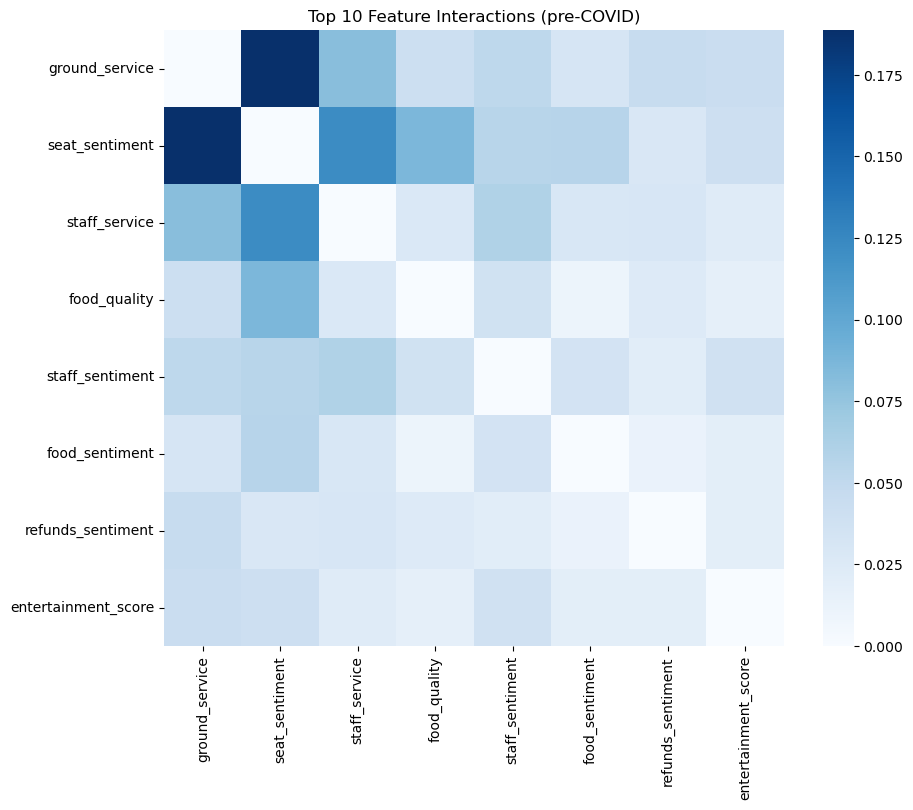

In [19]:
X_pre = df_pre_data[pre_feats]
y_pre= df_pre_data["overall_rating"]
top_pre = get_interactions(X_pre, y_pre, "pre-COVID", top_n=10)

- Train LightGBM → get SHAP interaction values → rank top-N pairs.  
- Add each pair (f1×f2) → test with LightGBM for RMSE/R² change vs baseline.  
- Fit OLS baseline → add interactions one by one → run ANOVA (F, p).  
- Report SHAP scores, predictive lift, and statistical significance.  

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

def test_interactions_linear(X, y, top_interactions, period_name):
    results = []
    
    df = X.copy()
    df["y"] = y
    formula_base = "y ~ " + " + ".join(X.columns)
    base_model = smf.ols(formula_base, data=df).fit()

    print(f"\n=== {period_name} Baseline OLS ===")
    print(base_model.summary().tables[0])  # model fit summary

    # --- Test each interaction separately ---
    for f1, f2, _ in top_interactions.itertuples(index=False):
        colname = f"{f1}_x_{f2}"
        df[colname] = df[f1] * df[f2]

        # Model with interaction term
        formula_int = formula_base + f" + {colname}"
        int_model = smf.ols(formula_int, data=df).fit()

        # Compare baseline vs interaction model
        anova_res = sm.stats.anova_lm(base_model, int_model)
        f_val = anova_res["F"].iloc[1]
        p_val = anova_res["Pr(>F)"].iloc[1]

        results.append((f"{f1} × {f2}", f_val, p_val, int_model.rsquared))

    df_results = pd.DataFrame(results, columns=["Interaction", "F", "p_value", "R2"])

    print(f"\n=== {period_name} Interaction Tests (OLS) ===")
    display(df_results.sort_values("p_value"))

    return df_results

In [21]:
X_pre = df_pre_data[pre_feats]
y_pre = df_pre_data["overall_rating"]

results_pre = test_interactions_linear(
    X_pre, y_pre, top_pre.head(5), "Pre-COVID"
)


=== Pre-COVID Baseline OLS ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     346.9
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        03:01:33   Log-Likelihood:                -1858.6
No. Observations:                1080   AIC:                             3749.
Df Residuals:                    1064   BIC:                             3829.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         

=== Pre-COVID Interaction Tests (OLS) ===


,Interaction,F,p_value,R2
4,staff_service × staff_sentiment,22.474120,0.000002,0.833769
3,staff_service × ground_service,22.453861,0.000002,0.833766
1,staff_service × seat_sentiment,19.549665,0.000011,0.833320
2,food_quality × seat_sentiment,11.953255,0.000567,0.832142
0,ground_service × seat_sentiment,7.260244,0.007161,0.831406


# During-COVID interaction analysis:


=== Top 10 Interactions (During-COVID) ===


,Feature1,Feature2,MeanAbsSHAP
82,staff_sentiment,topic_baggage,0.110768
14,staff_service,ground_service,0.087939
97,entertainment_sentiment,topic_baggage,0.072182
77,staff_sentiment,refunds_sentiment,0.058474
69,seat_sentiment,staff_sentiment,0.050885
88,refunds_sentiment,topic_baggage,0.050855
84,refunds_sentiment,lounge_sentiment,0.048996
43,food_quality,refunds_sentiment,0.046159
52,entertainment_score,staff_sentiment,0.045965
5,seat_comfort,seat_sentiment,0.044175


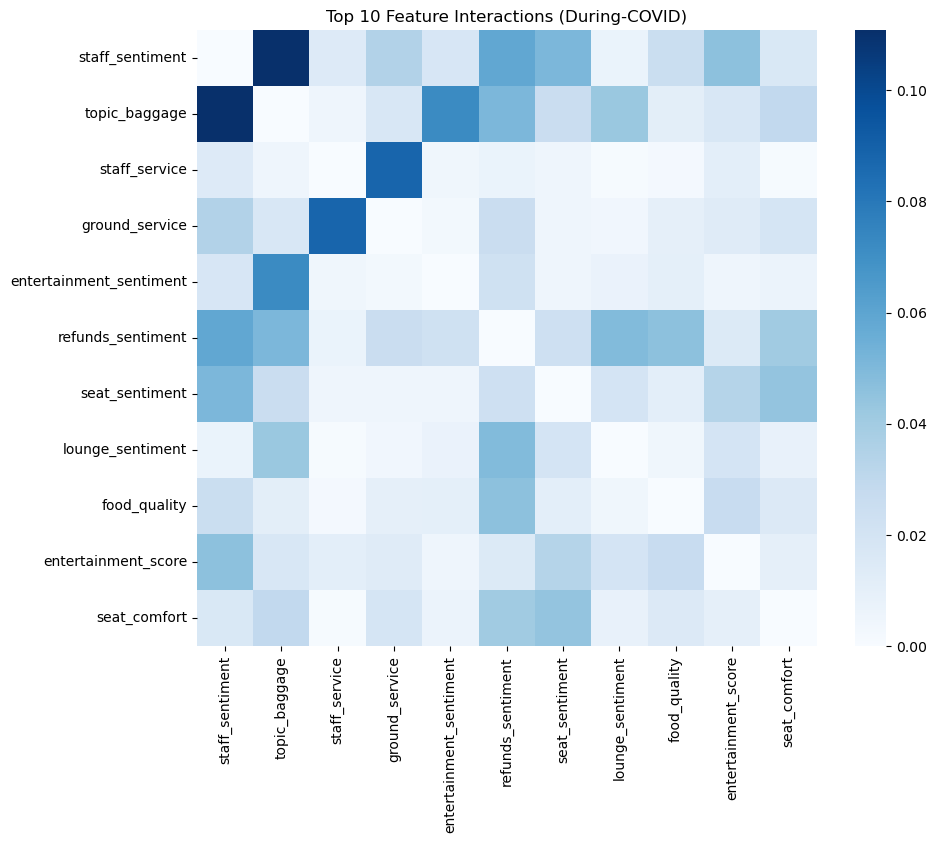

In [22]:
X_during = df_during_data[during_feats]
y_during = df_during_data["overall_rating"]

top_during = get_interactions(X_during, y_during, "During-COVID", top_n=10)

In [23]:
# During-COVID
X_during = df_during_data[during_feats]
y_during = df_during_data["overall_rating"]

results_during = test_interactions_linear(
    X_during, y_during, top_during.head(5), "During-COVID"
)


=== During-COVID Baseline OLS ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     33.08
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           3.93e-38
Time:                        03:02:21   Log-Likelihood:                -281.87
No. Observations:                 153   AIC:                             595.7
Df Residuals:                     137   BIC:                             644.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         

=== During-COVID Interaction Tests (OLS) ===


,Interaction,F,p_value,R2
1,staff_service × ground_service,11.506357,0.000909,0.800502
3,staff_sentiment × refunds_sentiment,2.358465,0.126928,0.787312
4,seat_sentiment × staff_sentiment,2.128726,0.146867,0.786958
2,entertainment_sentiment × topic_baggage,1.422126,0.235130,0.785863
0,staff_sentiment × topic_baggage,0.612978,0.435030,0.784594


# Post-COVID interaction analysis: 


=== Top 10 Interactions (Post-COVID) ===


,Feature1,Feature2,MeanAbsSHAP
14,staff_service,ground_service,0.124711
103,airport_service_sentiment,topic_baggage,0.072905
32,ground_service,staff_sentiment,0.069453
20,staff_service,staff_sentiment,0.062254
30,ground_service,food_sentiment,0.054479
21,staff_service,refunds_sentiment,0.048123
98,lounge_sentiment,topic_baggage,0.047975
89,staff_sentiment,topic_baggage,0.045547
0,seat_comfort,staff_service,0.044209
84,staff_sentiment,refunds_sentiment,0.043470


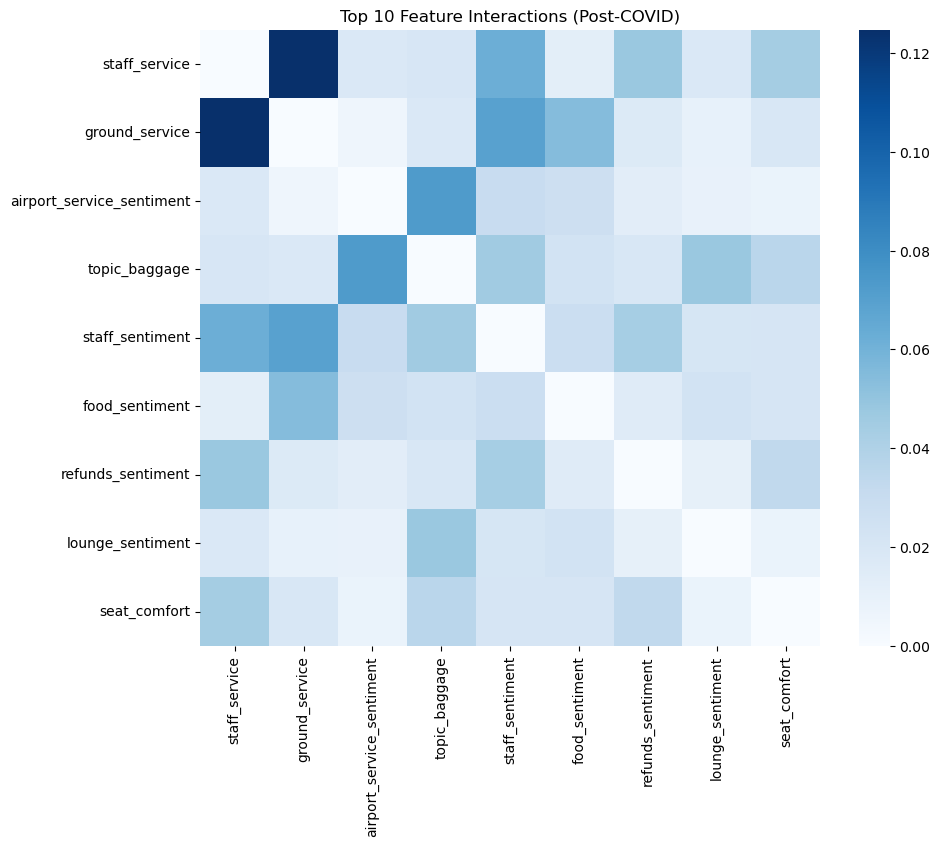

In [24]:
X_post = df_post_data[post_feats]
y_post = df_post_data["overall_rating"]

top_post = get_interactions(X_post, y_post, "Post-COVID", top_n=10)

In [25]:
X_post = df_post_data[post_feats]
y_post = df_post_data["overall_rating"]

results_post = test_interactions_linear(
    X_post, y_post, top_post.head(5), "Post-COVID"
)


=== Post-COVID Baseline OLS ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     71.52
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           6.54e-77
Time:                        03:03:09   Log-Likelihood:                -414.78
No. Observations:                 242   AIC:                             861.6
Df Residuals:                     226   BIC:                             917.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         

=== Post-COVID Interaction Tests (OLS) ===


,Interaction,F,p_value,R2
0,staff_service × ground_service,32.636344,3.498891e-08,0.848031
3,staff_service × staff_sentiment,11.362939,8.817129e-04,0.834354
4,ground_service × food_sentiment,5.823908,1.661043e-02,0.830379
2,ground_service × staff_sentiment,4.598568,3.307065e-02,0.829473
1,airport_service_sentiment × topic_baggage,0.564373,4.532886e-01,0.826424


# ICE + PDP + 2PDP Plots of Top Interactions

In [26]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

def plot_interactions(X, y, features, model, period_name):
    model.fit(X, y)

    # --- PDP + ICE combined (1D) ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Feature 1
    PartialDependenceDisplay.from_estimator(
        model, X, [features[0]], ax=ax[0], kind="both", subsample=50, random_state=42
    )
    ax[0].set_title(f"{period_name}: PDP + ICE {features[0]}")

    # Feature 2
    PartialDependenceDisplay.from_estimator(
        model, X, [features[1]], ax=ax[1], kind="both", subsample=50, random_state=42
    )
    ax[1].set_title(f"{period_name}: PDP + ICE {features[1]}")

    plt.tight_layout()
    plt.show()

    # --- 2D PDP for interaction ---
    fig, ax = plt.subplots(figsize=(6, 5))
    PartialDependenceDisplay.from_estimator(
        model, X, [features], ax=ax, kind="average", grid_resolution=30
    )
    ax.set_title(f"{period_name}: 2D PDP {features[0]} × {features[1]}")
    plt.tight_layout()
    plt.show()

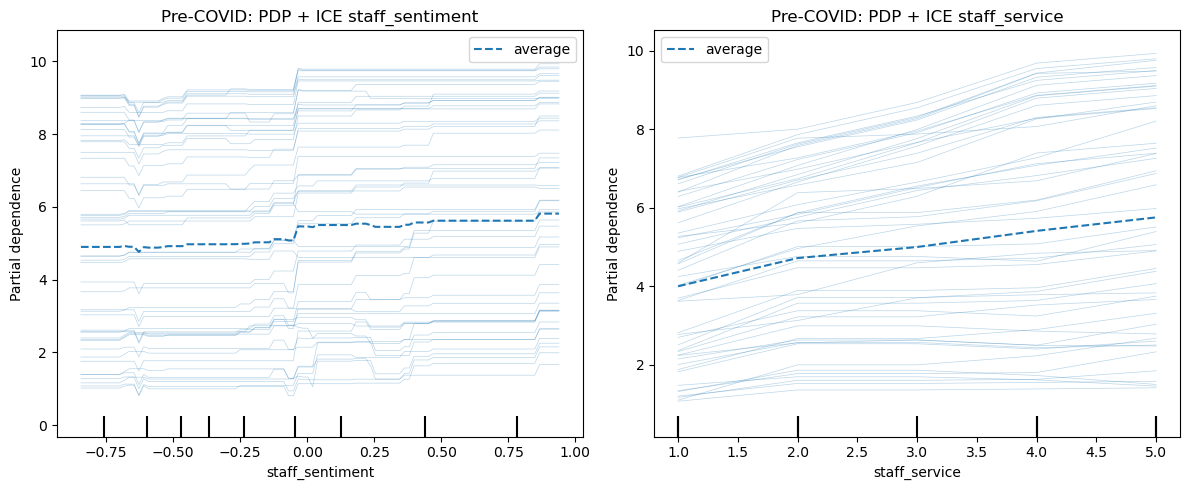

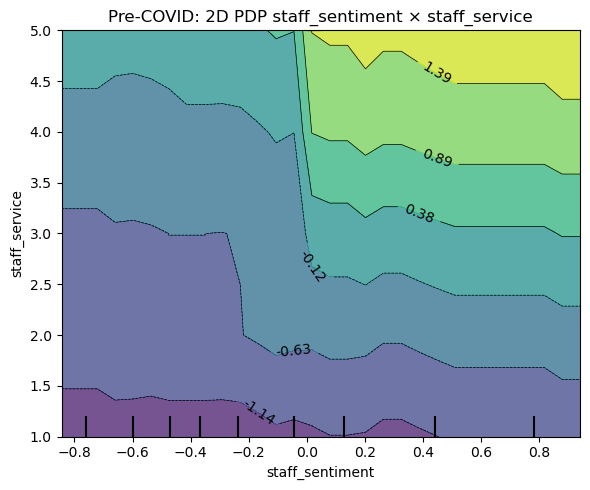

In [27]:
# Pre-COVID strongest interaction
X_pre = df_pre_data[pre_feats].fillna(0)
y_pre = df_pre_data["overall_rating"]
plot_interactions(X_pre, y_pre, ["staff_sentiment", "staff_service"], GradientBoostingRegressor(), "Pre-COVID")

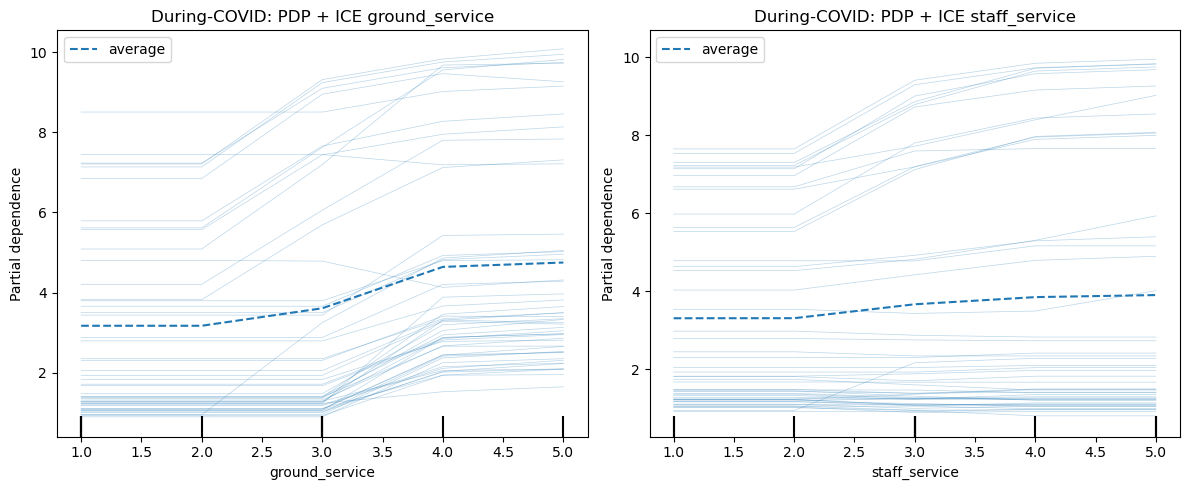

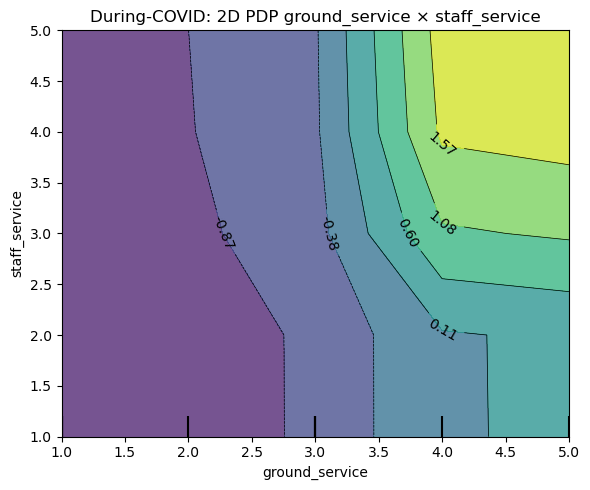

In [28]:
# During-COVID strongest interaction
X_during = df_during_data[during_feats].fillna(0)
y_during = df_during_data["overall_rating"]
plot_interactions(X_during, y_during, ["ground_service", "staff_service"], GradientBoostingRegressor(), "During-COVID")

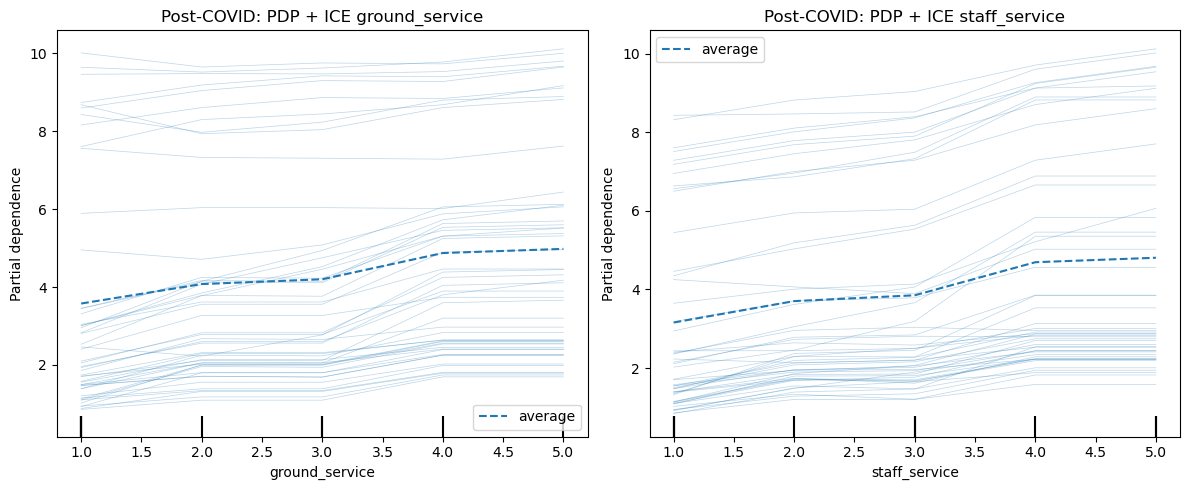

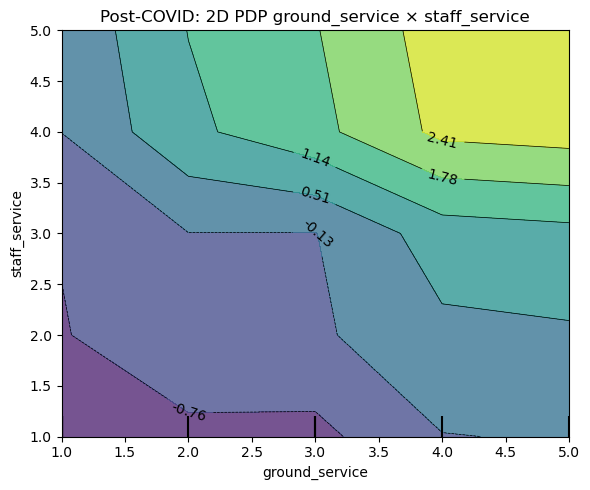

In [29]:
# Post-COVID strongest interaction
X_post = df_post_data[post_feats].fillna(0)
y_post = df_post_data["overall_rating"]
plot_interactions(X_post, y_post, ["ground_service", "staff_service"], GradientBoostingRegressor(), "Post-COVID")

## Statstical Testing for Feature Interaction

### Validation of Top Interactions (OLS + Permutation + Bootstrap)

Purpose: statistically verify that specific feature interactions add real signal beyond main effects.

Steps:
- Fit an OLS with main effects (f1, f2) and their product (f1×f2); inspect the interaction coefficient and R².
- Run a permutation test on y to check that the observed R² is far from chance.
- Bootstrap the interaction coefficient to obtain a 95% confidence interval for its magnitude and sign.

Interpretation guide:
- Significant positive coef → synergy (combined effect > sum of parts).
- Significant negative coef → conflict (combined effect < sum of parts).
- High true R² vs. permuted and a CI not crossing 0 → robust interaction.

In [30]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap

def stability_test(X, y, top_pairs, n_runs=5, sample_size=3000):
    stability = {pair: 0 for pair in top_pairs}

    for seed in range(n_runs):
        np.random.seed(seed)
        sample_idx = np.random.choice(X.index, size=min(sample_size, len(X)), replace=False)
        X_sample = X.loc[sample_idx].fillna(0)
        y_sample = y.loc[sample_idx]

        model = lgb.LGBMRegressor(n_estimators=500, max_depth=6, random_state=seed, verbose=-1)
        model.fit(X_sample, y_sample)

        explainer = shap.TreeExplainer(model)
        shap_inter = explainer.shap_interaction_values(X_sample)

        # Rank interactions
        feat_names = X_sample.columns
        pairs = []
        for i in range(len(feat_names)):
            for j in range(i+1, len(feat_names)):
                score = np.mean(np.abs(shap_inter[:, i, j]))
                pairs.append((feat_names[i], feat_names[j], score))
        df_pairs = pd.DataFrame(pairs, columns=["Feature1","Feature2","MeanAbsSHAP"]).sort_values("MeanAbsSHAP", ascending=False)

        # Check if our target pairs appear in top 10
        top10 = set([tuple(sorted((a,b))) for a,b in df_pairs.head(10)[["Feature1","Feature2"]].values])
        for p in top_pairs:
            if tuple(sorted(p)) in top10:
                stability[p] += 1

    return stability

In [31]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def regression_test(X, y, f1, f2):
    X_int = X.copy()
    X_int[f"{f1}_{f2}"] = X_int[f1] * X_int[f2]

    X_train, X_test, y_train, y_test = train_test_split(X_int, y, test_size=0.2, random_state=42)

    # Add constant for OLS
    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    pred = model.predict(sm.add_constant(X_test))

    return model.summary(), r2_score(y_test, pred)

# Pre Covid


=== Pre-COVID Validation ===

OLS Results for staff_sentiment × staff_service
                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     812.6
Date:                Mon, 01 Sep 2025   Prob (F-statistic):          6.68e-276
Time:                        03:15:51   Log-Likelihood:                -2177.2
No. Observations:                1080   AIC:                             4362.
Df Residuals:                    1076   BIC:                             4382.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

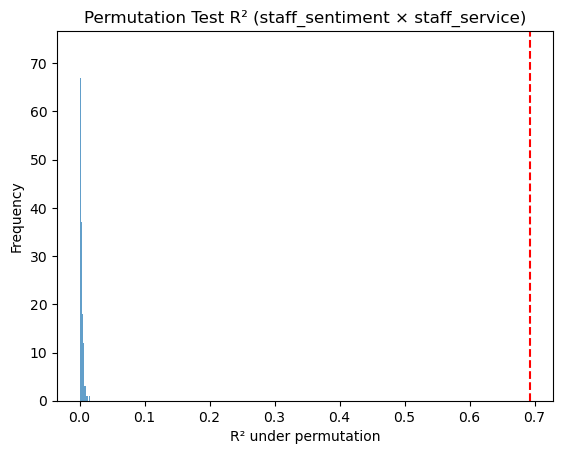

True R²: 0.694
Mean permuted R²: 0.003
Percentile rank of True R²: 100.0%


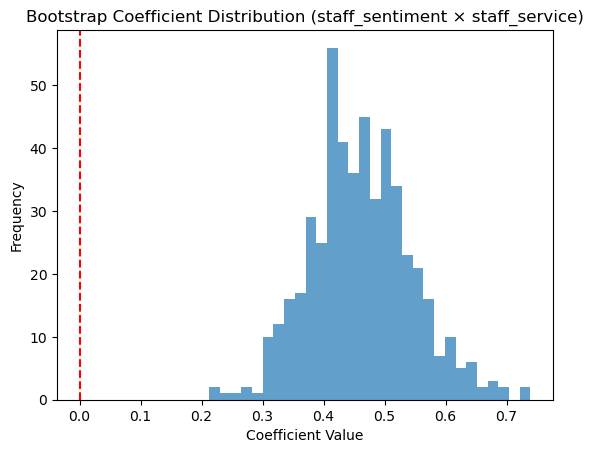

Bootstrap mean coef: 0.462
95% CI: [0.313, 0.637]


In [33]:
# =========================================================
# VALIDATION OF TOP INTERACTIONS (Pre & During COVID)
# =========================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# =============== 1. OLS REGRESSION ===============
def test_interaction_ols(df, f1, f2, y_col="overall_rating"):
    X = df[[f1, f2]].copy()
    X[f"{f1}_{f2}"] = X[f1] * X[f2]
    X = sm.add_constant(X)
    y = df[y_col]

    model = sm.OLS(y, X).fit()
    print(f"\nOLS Results for {f1} × {f2}")
    print(model.summary())

    return model.rsquared, model.params[f"{f1}_{f2}"]

# =============== 2. Permutation Test ===============
def permutation_test(df, f1, f2, y_col="overall_rating", n_perms=500):
    # True R²
    X = df[[f1, f2]].copy()
    X[f"{f1}_{f2}"] = X[f1] * X[f2]
    X = sm.add_constant(X)
    y = df[y_col]
    model = sm.OLS(y, X).fit()
    true_r2 = model.rsquared

    perm_r2s = []
    for _ in range(n_perms):
        y_perm = np.random.permutation(y)
        model_perm = sm.OLS(y_perm, X).fit()
        perm_r2s.append(model_perm.rsquared)

    plt.hist(perm_r2s, bins=30, alpha=0.7)
    plt.axvline(true_r2, color="red", linestyle="--")
    plt.title(f"Permutation Test R² ({f1} × {f2})")
    plt.xlabel("R² under permutation")
    plt.ylabel("Frequency")
    plt.show()

    print(f"True R²: {true_r2:.3f}")
    print(f"Mean permuted R²: {np.mean(perm_r2s):.3f}")
    print(f"Percentile rank of True R²: {np.mean(true_r2 > np.array(perm_r2s)) * 100:.1f}%")

# =============== 3. Bootstrap CI ===============
def bootstrap_interaction(df, f1, f2, y_col="overall_rating", n_boot=500):
    coefs = []
    for _ in range(n_boot):
        df_boot = resample(df, replace=True, n_samples=len(df))
        X = df_boot[[f1, f2]].copy()
        X[f"{f1}_{f2}"] = X[f1] * X[f2]
        X = sm.add_constant(X)
        y = df_boot[y_col]
        model = sm.OLS(y, X).fit()
        coefs.append(model.params[f"{f1}_{f2}"])

    mean_coef = np.mean(coefs)
    ci_lower, ci_upper = np.percentile(coefs, [2.5, 97.5])

    plt.hist(coefs, bins=30, alpha=0.7)
    plt.axvline(0, color="red", linestyle="--")
    plt.title(f"Bootstrap Coefficient Distribution ({f1} × {f2})")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Frequency")
    plt.show()

    print(f"Bootstrap mean coef: {mean_coef:.3f}")
    print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

# =========================================================
# RUN VALIDATIONS
# =========================================================

# --- Pre-COVID: seat_comfort × food_quality ---
print("\n=== Pre-COVID Validation ===")
r2_pre, coef_pre = test_interaction_ols(df_pre_data, "staff_sentiment", "staff_service")
permutation_test(df_pre_data, "staff_sentiment", "staff_service")
bootstrap_interaction(df_pre_data, "staff_sentiment", "staff_service")

# During Covid


=== During-COVID Validation ===

OLS Results for ground_service × staff_service
                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     93.60
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           4.21e-34
Time:                        03:17:36   Log-Likelihood:                -317.93
No. Observations:                 153   AIC:                             643.9
Df Residuals:                     149   BIC:                             656.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

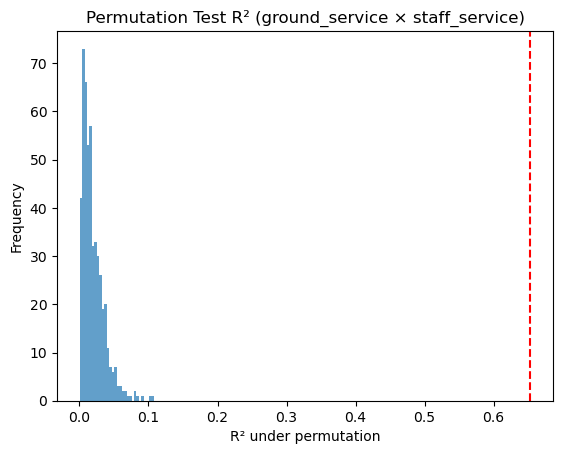

True R²: 0.653
Mean permuted R²: 0.020
Percentile rank of True R²: 100.0%


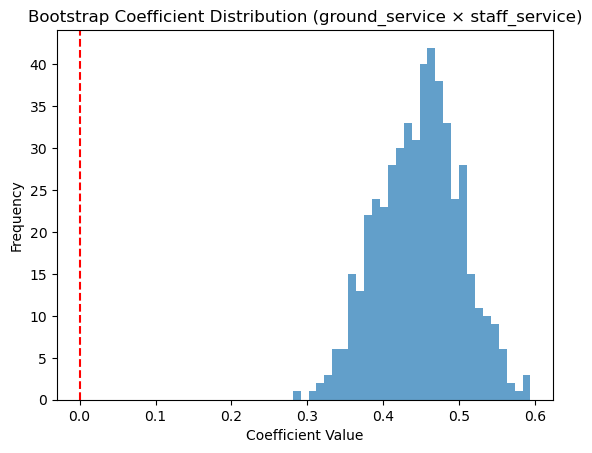

Bootstrap mean coef: 0.448
95% CI: [0.342, 0.551]


In [34]:
# --- During-COVID: ground_service × staff_sentiment ---
print("\n=== During-COVID Validation ===")
r2_during, coef_during = test_interaction_ols(df_during_data, "ground_service", "staff_service")
permutation_test(df_during_data, "ground_service", "staff_service")
bootstrap_interaction(df_during_data,"ground_service", "staff_service")

# Post Covid


=== Post-COVID Validation ===

OLS Results for ground_service × staff_service
                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     325.8
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           6.05e-84
Time:                        03:17:50   Log-Likelihood:                -429.08
No. Observations:                 242   AIC:                             866.2
Df Residuals:                     238   BIC:                             880.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

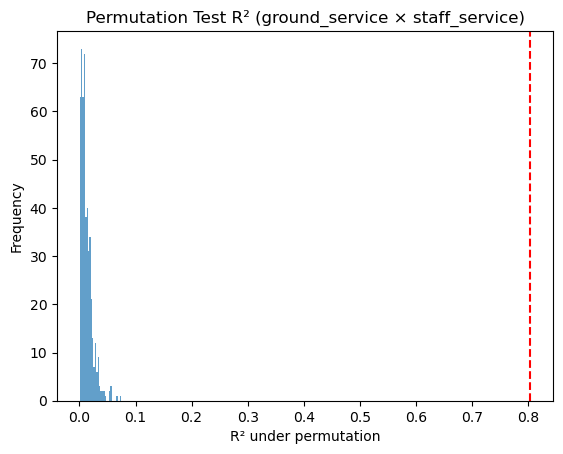

True R²: 0.804
Mean permuted R²: 0.012
Percentile rank of True R²: 100.0%


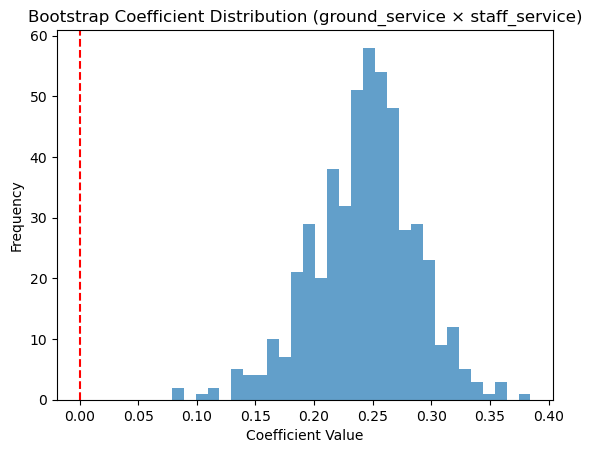

Bootstrap mean coef: 0.243
95% CI: [0.148, 0.323]


In [36]:
print("\n=== Post-COVID Validation ==="); r2_post, coef_post = test_interaction_ols(df_post_data, "ground_service", "staff_service")
permutation_test(df_post_data,"ground_service", "staff_service")
bootstrap_interaction(df_post_data, "ground_service", "staff_service")

# MCR Shortlist compared to Full Feature SHAP Interaction 

### Feature Interaction Analysis: Full vs. MCR Shortlist

Test feature interactions under two setups:

1. **Full Feature Set** – all features (excluding target, metadata, and collinear/leaky ones).  
2. **MCR Shortlist** – only **Core + Volatile features** from MCR screening.  

For each setup, the **top-N feature interactions** are identified using SHAP interaction values derived from a LightGBM model,
enabling a comparison of whether MCR-based filtering emphasizes more meaningful brand-related dynamics.


>>> Running FULL feature interactions for Pre-COVID

=== Top 10 Interactions (Pre-COVID (All Features)) ===


,Feature1,Feature2,MeanAbsSHAP
176,food_quality,staff_sentiment,0.104714
71,seat_comfort,staff_service,0.097879
73,seat_comfort,food_quality,0.090258
78,seat_comfort,food_sentiment,0.079956
174,food_quality,food_sentiment,0.072761
111,staff_service,food_sentiment,0.065887
72,seat_comfort,ground_service,0.050446
80,seat_comfort,staff_sentiment,0.049481
113,staff_service,staff_sentiment,0.047056
106,staff_service,food_quality,0.037190


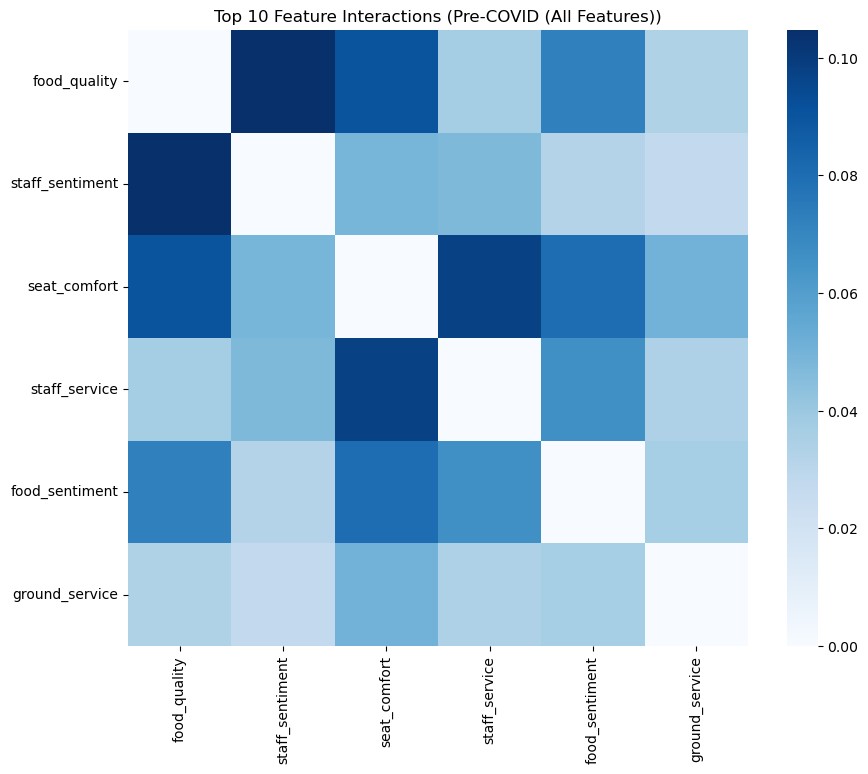


>>> Running MCR-SHORTLIST feature interactions for Pre-COVID

=== Top 10 Interactions (Pre-COVID (MCR Shortlist)) ===


,Feature1,Feature2,MeanAbsSHAP
42,food_quality,staff_sentiment,0.103044
0,seat_comfort,staff_service,0.102450
2,seat_comfort,food_quality,0.089049
4,seat_comfort,food_sentiment,0.088691
40,food_quality,food_sentiment,0.076448
17,staff_service,food_sentiment,0.065339
6,seat_comfort,staff_sentiment,0.054244
1,seat_comfort,ground_service,0.047849
19,staff_service,staff_sentiment,0.047005
61,food_sentiment,staff_sentiment,0.042292


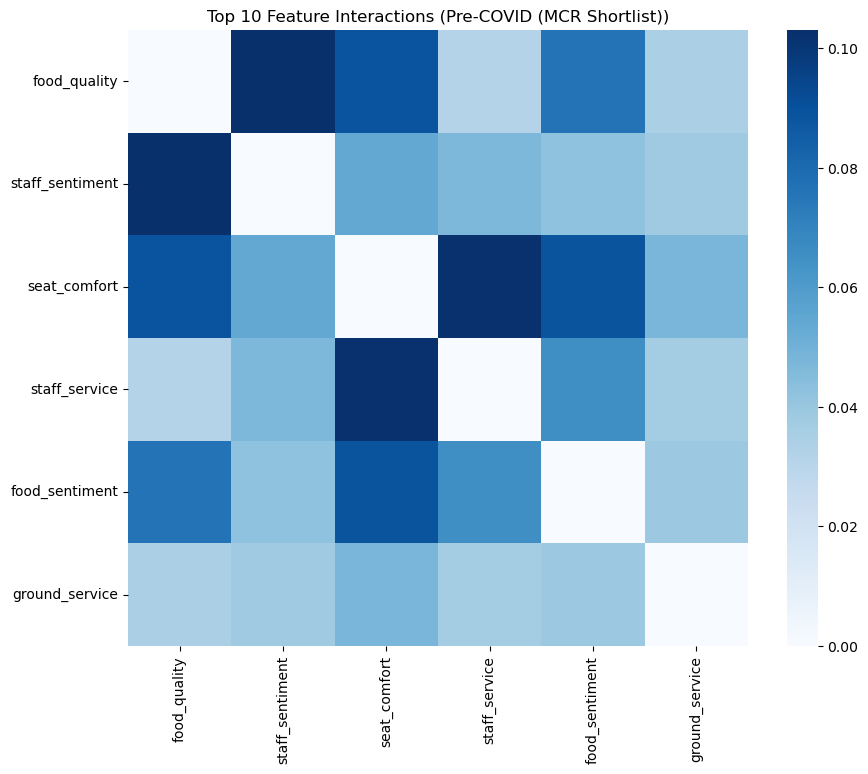

In [38]:
#  RUN BOTH: FULL SET vs SHORTLIST
def run_period_analysis(df_period, mcr_feats, period_name, top_n=10):
    y = df_period["overall_rating"]

    # (A) All features (drop target + metadata + redundant/leaky vars)
    drop_cols = [
        "overall_rating",     # target
        "review_date",        # timestamp
        "sentiment_score",    # redundant with aspect sentiments
        "optimism", "joy", "anger", "sadness",  # emotional overlaps
        "recommended",        # outcome label
        "covid_period",       # derived label
        "value_for_money"     # often collinear with rating
    ]
    X_all = df_period.drop(columns=[c for c in drop_cols if c in df_period.columns])

    print(f"\n>>> Running FULL feature interactions for {period_name}")
    inter_all = get_interactions(X_all, y, f"{period_name} (All Features)", top_n)

    # (B) MCR-shortlisted features
    X_mcr = df_period[mcr_feats]
    print(f"\n>>> Running MCR-SHORTLIST feature interactions for {period_name}")
    inter_mcr = get_interactions(X_mcr, y, f"{period_name} (MCR Shortlist)", top_n)

    return inter_all, inter_mcr

#  RUN: PRE-COVID
inter_all_pre, inter_mcr_pre = run_period_analysis(
    df_pre_data,
    pre_feats,
    "Pre-COVID",
    top_n=10
)


>>> Running FULL feature interactions for During-COVID

=== Top 10 Interactions (During-COVID (All Features)) ===


,Feature1,Feature2,MeanAbsSHAP
176,food_quality,staff_sentiment,0.115366
155,ground_service,topic_business_experience,0.100143
78,seat_comfort,food_sentiment,0.072233
145,ground_service,staff_sentiment,0.067271
178,food_quality,refunds_sentiment,0.053022
72,seat_comfort,ground_service,0.052211
375,staff_sentiment,topic_business_experience,0.050072
367,staff_sentiment,refunds_sentiment,0.043413
326,food_sentiment,topic_business_experience,0.038666
318,food_sentiment,refunds_sentiment,0.034233


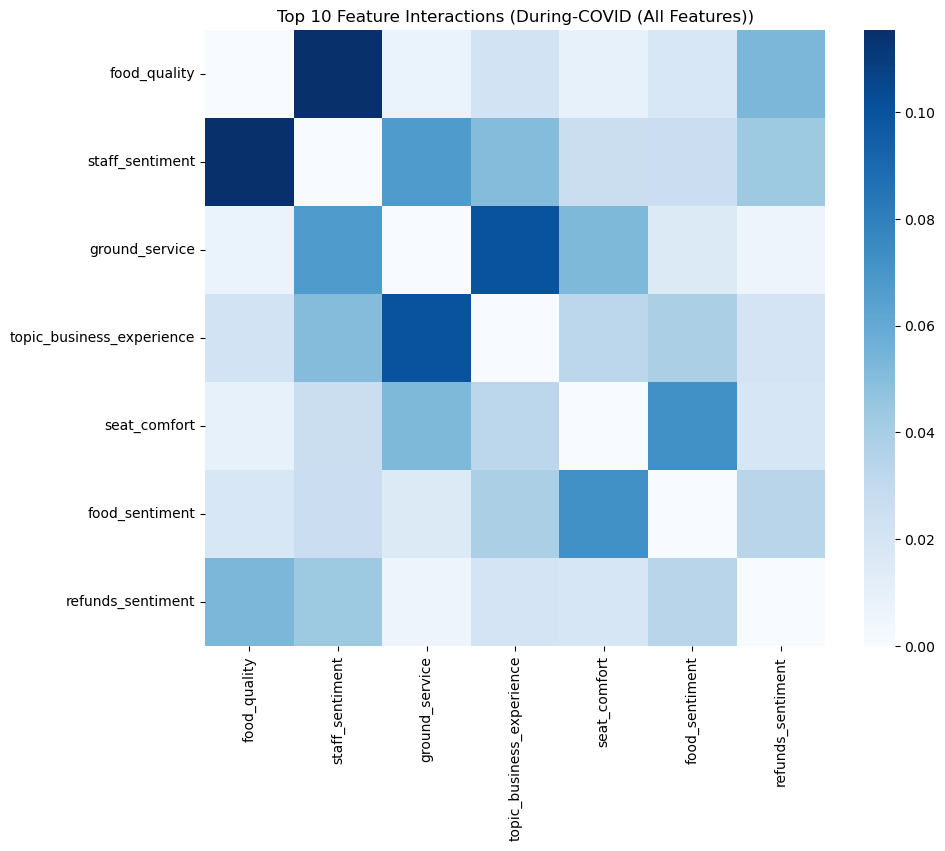


>>> Running MCR-SHORTLIST feature interactions for During-COVID

=== Top 10 Interactions (During-COVID (MCR Shortlist)) ===


,Feature1,Feature2,MeanAbsSHAP
42,food_quality,staff_sentiment,0.120879
38,ground_service,topic_business_experience,0.114934
31,ground_service,staff_sentiment,0.077118
4,seat_comfort,food_sentiment,0.072371
83,staff_sentiment,topic_business_experience,0.069454
37,ground_service,topic_refunds_lounge,0.049501
43,food_quality,refunds_sentiment,0.047688
1,seat_comfort,ground_service,0.043168
70,seat_sentiment,refunds_sentiment,0.041723
19,staff_service,staff_sentiment,0.041584


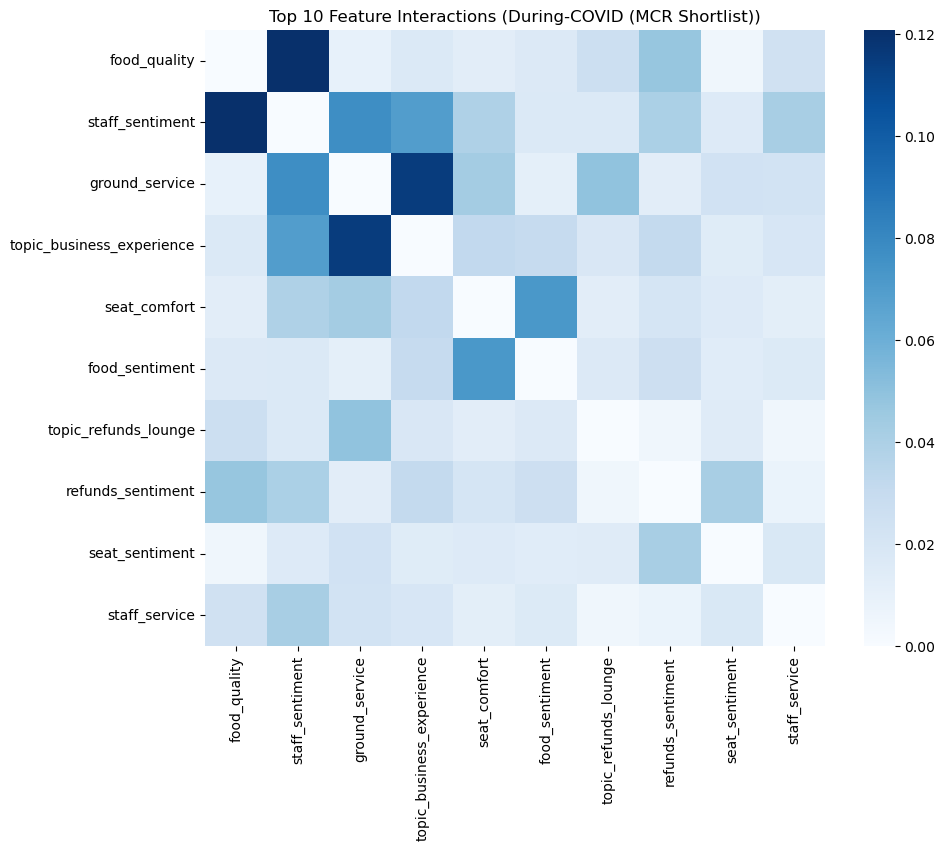

In [39]:
# DURING-COVID ANALYSIS
inter_all_during, inter_mcr_during = run_period_analysis(
    df_during_data,
    during_feats,
    "During-COVID",
    top_n=10
)


>>> Running FULL feature interactions for post-COVID

=== Top 10 Interactions (post-COVID (All Features)) ===


,Feature1,Feature2,MeanAbsSHAP
143,ground_service,food_sentiment,0.117484
72,seat_comfort,ground_service,0.102031
154,ground_service,topic_refunds_lounge,0.059547
138,ground_service,food_quality,0.049190
80,seat_comfort,staff_sentiment,0.046651
78,seat_comfort,food_sentiment,0.041667
368,staff_sentiment,lounge_sentiment,0.039269
185,food_quality,topic_refunds_lounge,0.037332
180,food_quality,entertainment_sentiment,0.036943
111,staff_service,food_sentiment,0.032952


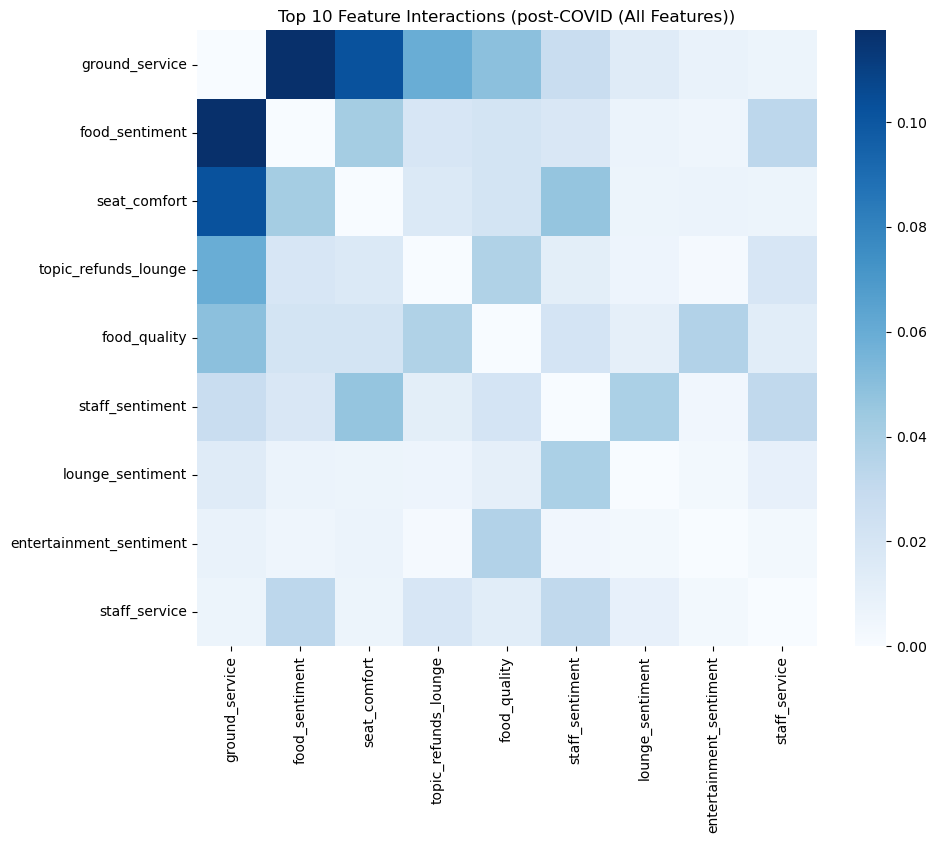


>>> Running MCR-SHORTLIST feature interactions for post-COVID

=== Top 10 Interactions (post-COVID (MCR Shortlist)) ===


,Feature1,Feature2,MeanAbsSHAP
28,ground_service,food_sentiment,0.122288
1,seat_comfort,ground_service,0.096917
36,ground_service,topic_refunds_lounge,0.073047
5,seat_comfort,staff_sentiment,0.056527
27,ground_service,food_quality,0.055680
71,staff_sentiment,lounge_sentiment,0.054335
47,food_quality,topic_refunds_lounge,0.044032
41,food_quality,staff_sentiment,0.042335
3,seat_comfort,food_sentiment,0.040130
50,food_sentiment,seat_sentiment,0.036543


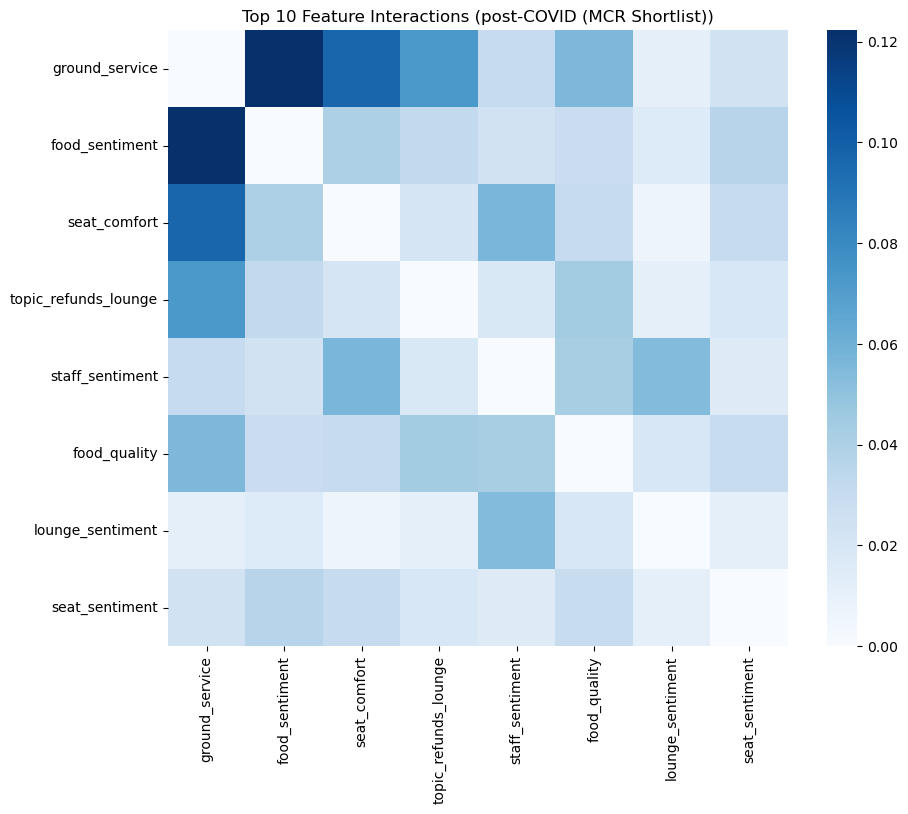

In [40]:
# Post-COVID ANALYSIS
inter_all_post, inter_mcr_post = run_period_analysis(
    df_post_data,
    post_feats,
    "post-COVID",
    top_n=10
)